In [1]:
try:
    from pathlib import Path
    import pandas as pd
    import matplotlib.pyplot as plt
    from lib.lib_utils import Utils
    import seaborn as sns
    from lib.lib_defect_analysis import Features
    from tqdm import tqdm
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn import ensemble
    from sklearn.inspection import permutation_importance
    from sklearn.metrics import mean_squared_error
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import MinMaxScaler
    import scipy
    import xgboost as xgb
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    from tqdm import tqdm
    from matplotlib.ticker import MaxNLocator
    import cv2
except Exception as e:
    print(f"Some module are missing: {e}\n")

In [2]:
data_path = Path().resolve().joinpath("data")
xyz_files_path = data_path.joinpath("xyz_files")
yolo_model_path = data_path.joinpath("models", "best.pt")
images_path = data_path.joinpath("images")
crops_path = data_path.joinpath("crops")
plot_path = Path().cwd().joinpath("plots")
pred_path = Path().cwd().joinpath("predictions")
plot_path.mkdir(exist_ok=True, parents=True)
pred_path.mkdir(exist_ok=True, parents=True)
plt.style.use("seaborn-v0_8-paper")

In [3]:
max_dim = [39.53476932, 34.27629786]
Utils.from_xyz_to_png(xyz_files_path, images_path, max_dim=max_dim, multiplier=6)

Utils.generate_yolo_crops(
    images_path,
    crops_path,
    yolo_model_path,
    binary_mask=True,
    device="cpu",
    confidence=0.75,
)

In [4]:
filepath = data_path.joinpath("features.csv").exists()

In [5]:
if not filepath:
    images = [
        f for f in crops_path.iterdir() if f.suffix.lower() in Features.IMAGE_EXTENSIONS
    ]

    features = {}

    for image in tqdm(images):
        if len(features) == 0:
            keys_list = list(features.keys())
            df = pd.DataFrame(columns=keys_list)
        else:
            features.clear()

        name = image.stem.split("_crop")[0]

        with open(str(xyz_files_path.joinpath(f"{name}.xyz")), "r") as file:
            first_line = file.readline()
        n_atoms = int(first_line.strip())

        features.update({"file_name": name})
        features.update({"n_atoms": n_atoms})

        shape_features = Features.extract_shape_features(image, grayscale=True)
        if shape_features is not None:
            features.update(shape_features)

        edge_features = Features.extract_edge_features(image, grayscale=True)
        if edge_features is not None:
            features.update(edge_features)

        texture_features = Features.extract_texture_features(image)
        if texture_features is not None:
            features.update(texture_features)

        new_row = pd.Series(features)
        df = pd.concat([df, new_row.to_frame().T], ignore_index=True)

    grouped_df = (
        df.groupby("file_name")
        .agg(
            {
                "n_atoms": "first",
                "area": "sum",
                "num_pixels": "sum",
                "perimeter": "sum",
                "circularity": lambda x: (x * df.loc[x.index, "area"]).sum()
                / df.loc[x.index, "area"].sum(),
                "solidity": lambda x: (x * df.loc[x.index, "area"]).sum()
                / df.loc[x.index, "area"].sum(),
                "compactness": lambda x: (x * df.loc[x.index, "area"]).sum()
                / df.loc[x.index, "area"].sum(),
                "feret_diameter": lambda x: (x * df.loc[x.index, "area"]).sum()
                / df.loc[x.index, "area"].sum(),
                "eccentricity": lambda x: (x * df.loc[x.index, "area"]).sum()
                / df.loc[x.index, "area"].sum(),
                "number_of_edges": lambda x: (x * df.loc[x.index, "area"]).sum()
                / df.loc[x.index, "area"].sum(),
                "edge_density": lambda x: (x * df.loc[x.index, "area"]).sum()
                / df.loc[x.index, "area"].sum(),
                "edge_density": lambda x: (x * df.loc[x.index, "area"]).sum()
                / df.loc[x.index, "area"].sum(),
                "GLCM_contrast": lambda x: (x * df.loc[x.index, "area"]).sum()
                / df.loc[x.index, "area"].sum(),
                "GLCM_homogeneity": lambda x: (x * df.loc[x.index, "area"]).sum()
                / df.loc[x.index, "area"].sum(),
                "GLCM_energy": lambda x: (x * df.loc[x.index, "area"]).sum()
                / df.loc[x.index, "area"].sum(),
                "GLCM_correlation": lambda x: (x * df.loc[x.index, "area"]).sum()
                / df.loc[x.index, "area"].sum(),
            }
        )
        .reset_index()
    )

    #
    original_df = pd.read_csv(xyz_files_path.joinpath("target_graphene_dftb.csv"))

    energy_dict = original_df.set_index("file_name")["total_energy_eV"].to_dict()
    fermi_dict = original_df.set_index("file_name")["fermi_level_ev"].to_dict()
    ip_dict = original_df.set_index("file_name")["IP_ev"].to_dict()
    ea_dict = original_df.set_index("file_name")["EA_ev"].to_dict()
    band_gap_dict = original_df.set_index("file_name")["band_gap_ev"].to_dict()
    current_dict = original_df.set_index("file_name")["current"].to_dict()
    flake_total_area_dict = original_df.set_index("file_name")[
        "flake_total_area"
    ].to_dict()

    # Aggiunta della colonna total_energy al primo dataframe
    grouped_df["total_energy_eV"] = grouped_df["file_name"].map(energy_dict)
    grouped_df["fermi_level_ev"] = grouped_df["file_name"].map(fermi_dict)
    grouped_df["IP_ev"] = grouped_df["file_name"].map(ip_dict)
    grouped_df["EA_ev"] = grouped_df["file_name"].map(ea_dict)
    grouped_df["band_gap_ev"] = grouped_df["file_name"].map(band_gap_dict)
    grouped_df["energy_per_atom"] = (
        grouped_df["total_energy_eV"] / grouped_df["n_atoms"]
    )
    grouped_df["current"] = grouped_df["file_name"].map(current_dict)
    grouped_df["flake_total_area"] = grouped_df["file_name"].map(flake_total_area_dict)
    grouped_df = grouped_df.dropna()

    grouped_df.to_csv(data_path.joinpath("features.csv"), index=False)
else:
    grouped_df = pd.read_csv(data_path.joinpath("features.csv"))

In [6]:
if grouped_df.isna().any().any():
    print("Avviso: Il DataFrame contiene valori NaN.")
else:
    print("Il DataFrame non contiene valori NaN.")

Il DataFrame non contiene valori NaN.


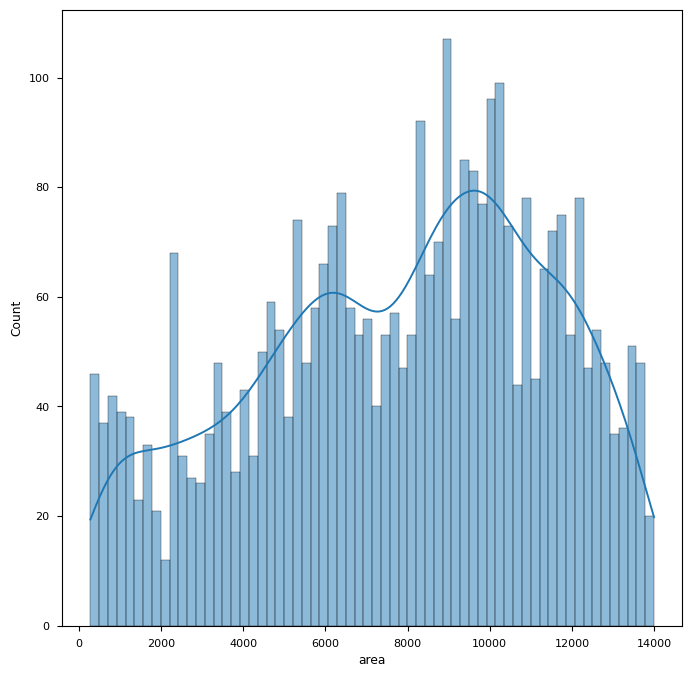

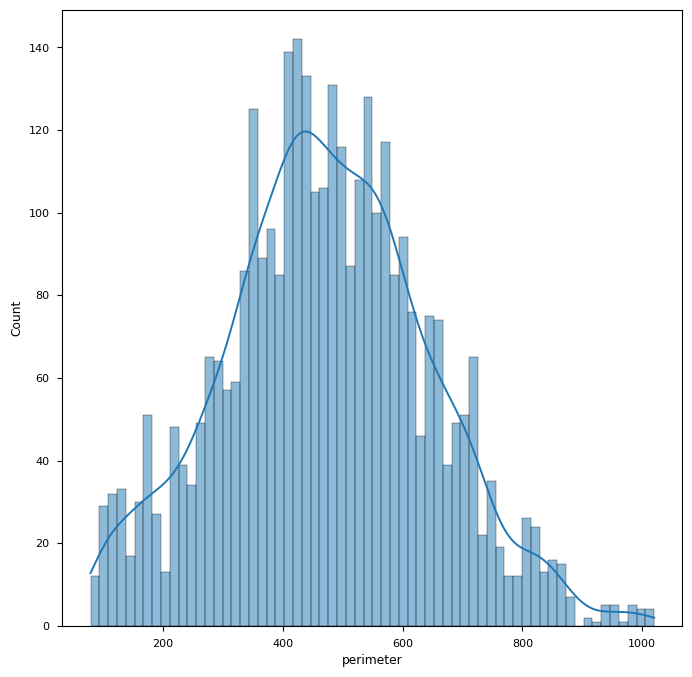

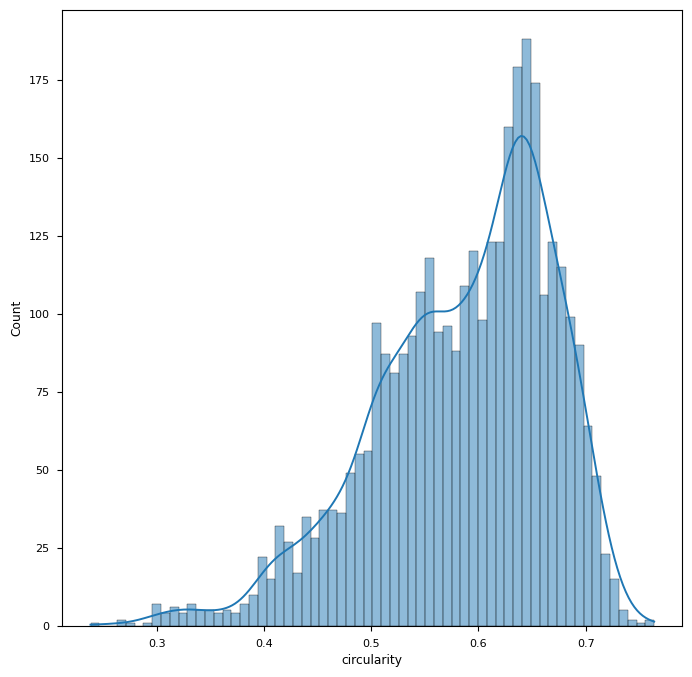

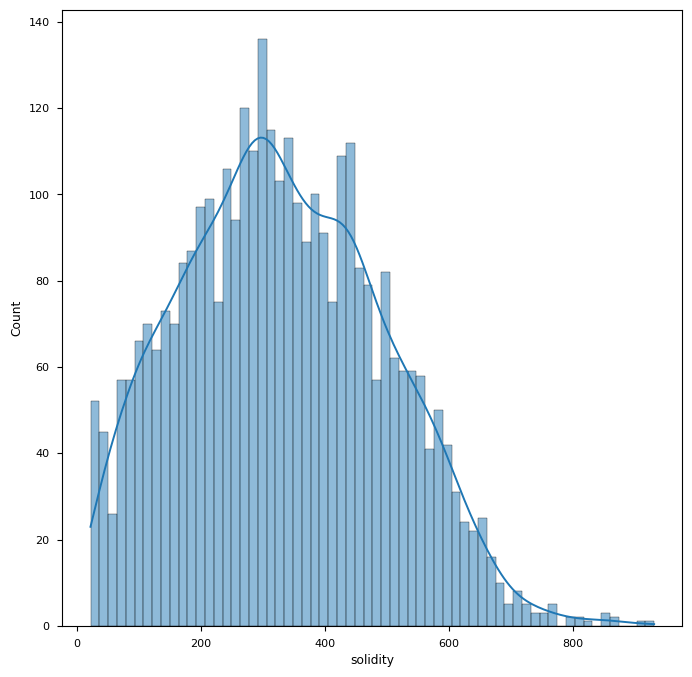

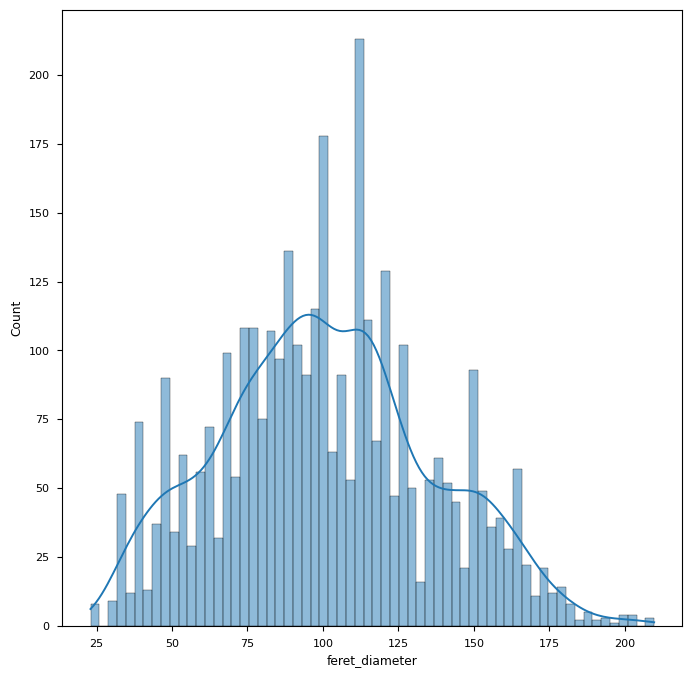

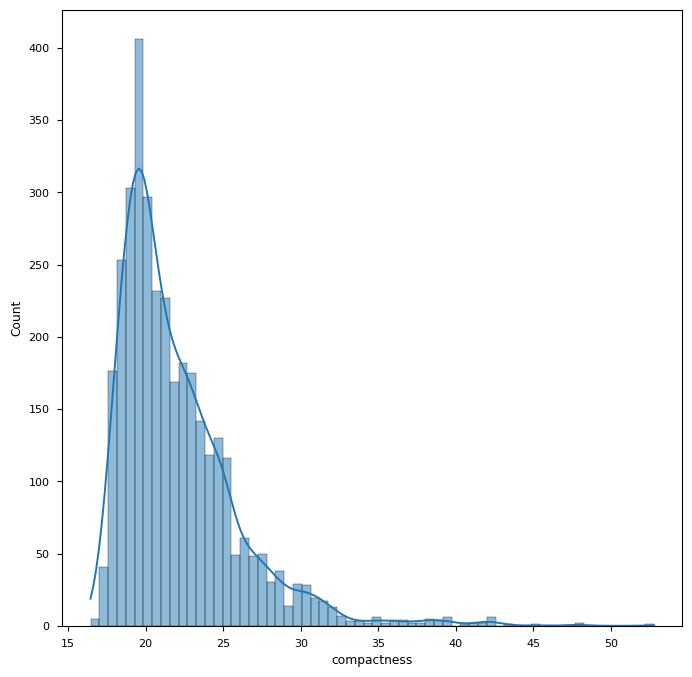

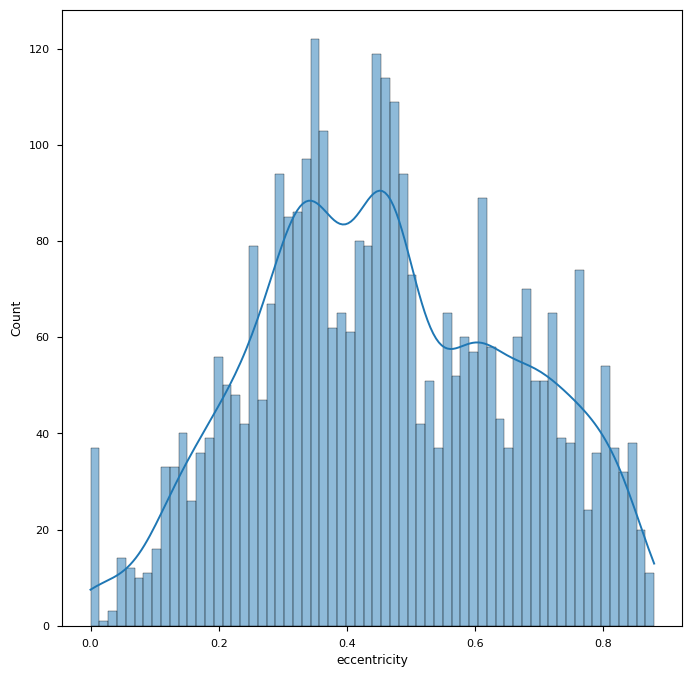

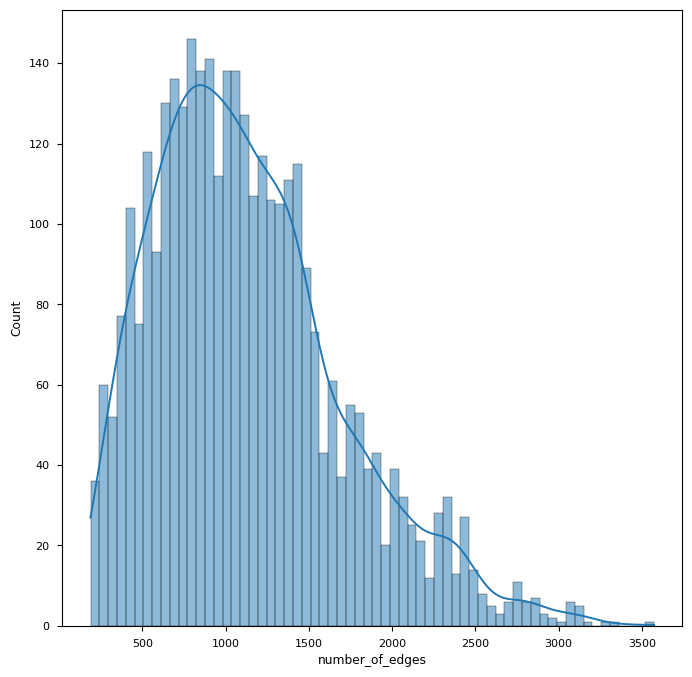

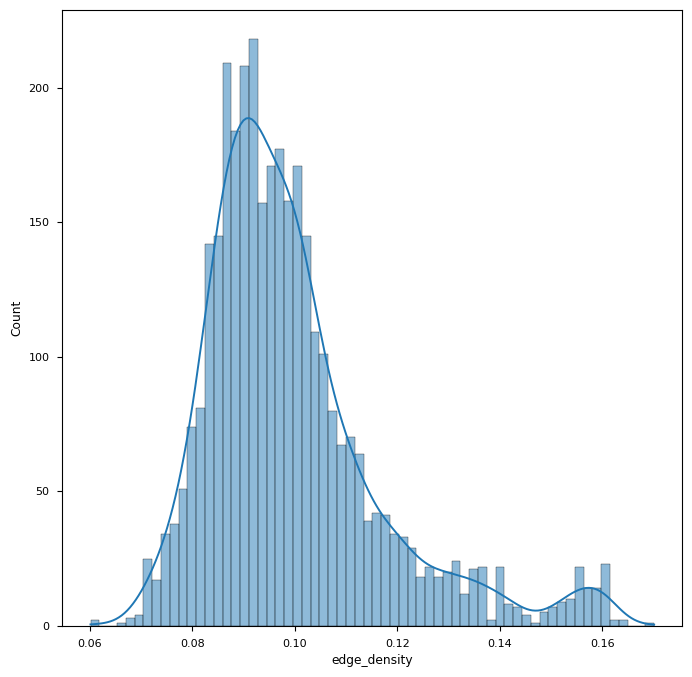

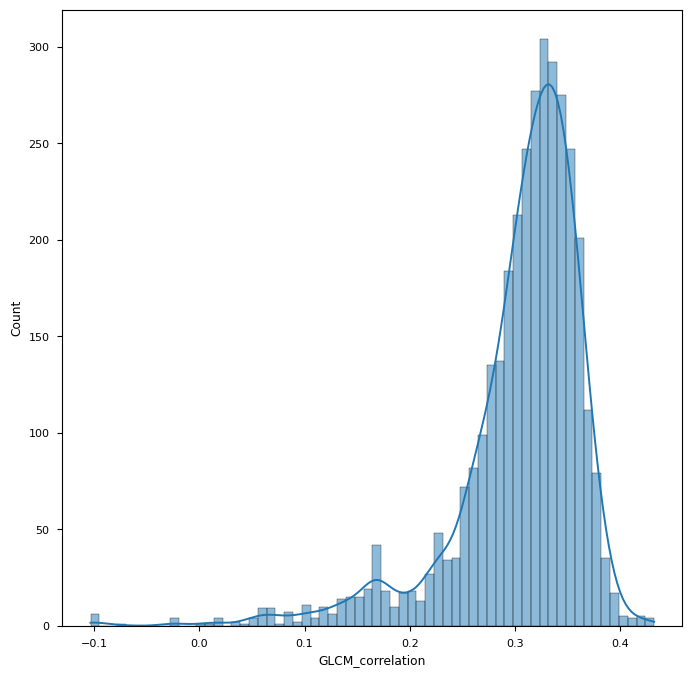

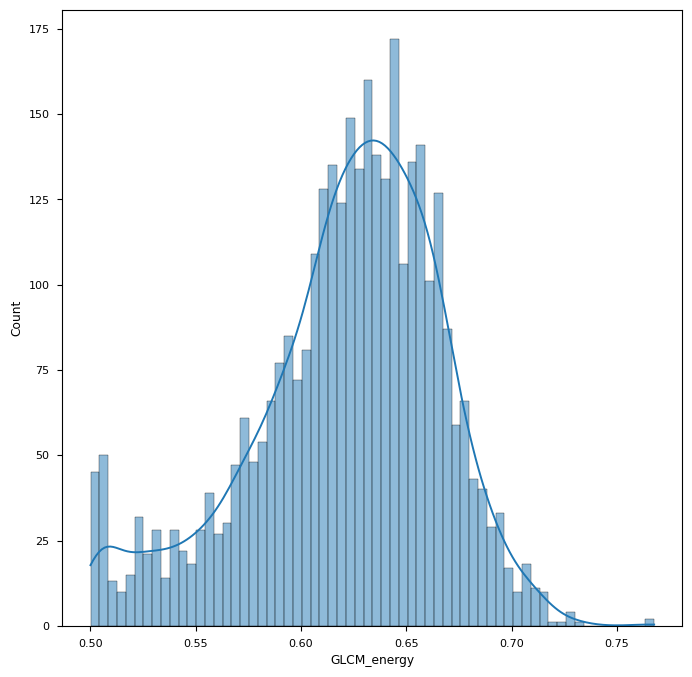

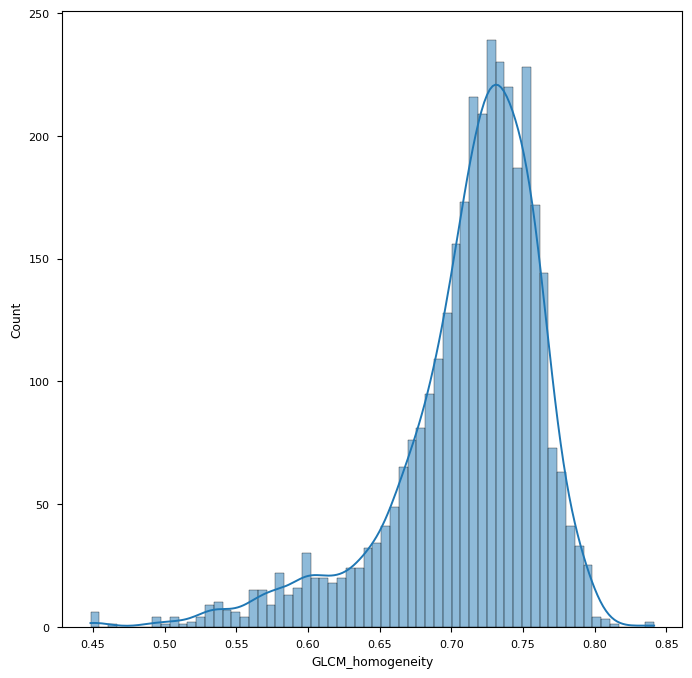

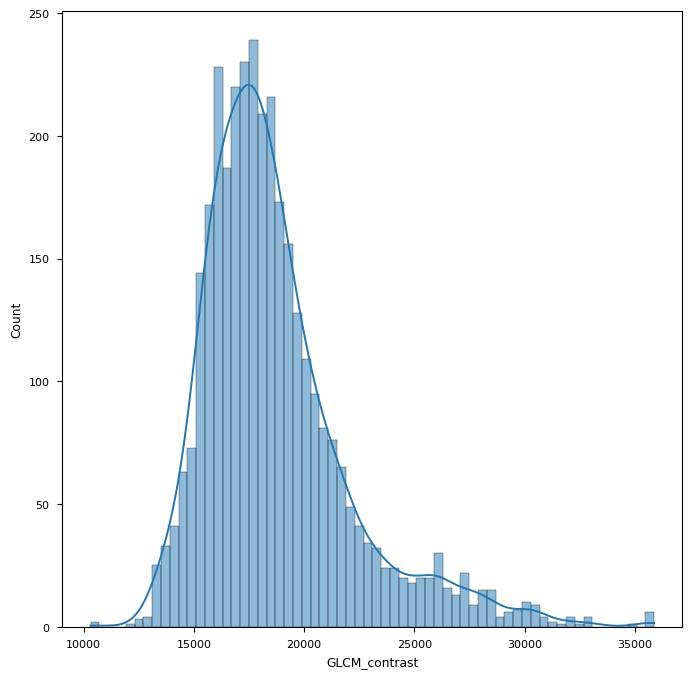

In [7]:
features_list = [
    "area",
    "perimeter",
    "circularity",
    "solidity",
    "feret_diameter",
    "compactness",
    "eccentricity",
    "number_of_edges",
    "edge_density",
    "GLCM_correlation",
    "GLCM_energy",
    "GLCM_homogeneity",
    "GLCM_contrast",
]
df_filtrato = grouped_df[grouped_df["area"] / grouped_df["flake_total_area"] < 0.3]
for feature in features_list:
    fig = plt.figure(figsize=(8, 8))
    sns.histplot(df_filtrato[feature], kde=True, bins=int(np.sqrt(len(grouped_df))))

In [13]:
features_list = [
    "area",
    "perimeter",
    "circularity",
    "solidity",
    "feret_diameter",
    "compactness",
    "eccentricity",
    "number_of_edges",
    "edge_density",
    "GLCM_correlation",
    "GLCM_energy",
    "GLCM_homogeneity",
    "GLCM_contrast",
]

params = {
    "n_estimators": 2770,
    "learning_rate": 0.010562915246990538,
    "max_depth": 10,
    "gamma": 0.0002985546393874009,
    "min_child_weight": 1.8685613953859606,
    "colsample_bytree": 0.9633894246849674,
    "subsample": 0.5195778253826636,
}
model = xgb.XGBRegressor(**params)
target_list = [
    "fermi_level_ev",
    "IP_ev",
    "EA_ev",
    "band_gap_ev",
    "energy_per_atom",
    "current",
    # "total_energy_eV",
]
scaled_targets = ["current"]
grouped_df = df_filtrato.copy()
X = grouped_df[features_list].values
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)

scores = []
for target in tqdm(target_list):
    target_scores = []
    file_names = grouped_df["file_name"]
    y = grouped_df[target].values.flatten()
    scaler2 = MinMaxScaler()
    y_norm = np.squeeze(scaler2.fit_transform(y.reshape(-1, 1)))
    # X_train, X_test, y_train, y_test = train_test_split(
    #     X, y, test_size=0.2, random_state=3333
    # )
    if target in scaled_targets:
        combined = list(zip(X_norm, y_norm, file_names))
    else:
        combined = list(zip(X, y, file_names))
    # Splittare combined
    train, test = train_test_split(combined, test_size=0.2, random_state=3333)

    # Separare X, y e file_names per train e test
    X_train, y_train, file_names_train = zip(*train)
    X_test, y_test, file_names_test = zip(*test)

    # Convertire in array numpy per l'utilizzo con scikit-learn
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    model.fit(X_train, y_train.ravel())

    y_pred = model.predict(X_test)
    if target in scaled_targets:
        y_test = scaler2.inverse_transform(y_test.reshape(-1, 1)).flatten()
        y_pred = scaler2.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    residual_error = y_test - y_pred
    results_df = pd.DataFrame(
        {
            f"{target}_predicted": y_pred,
            f"{target}_real": y_test,
            f"{target}_residual": residual_error,
        }
    )

    # Salvataggio del DataFrame in un CSV
    results_df.to_csv(pred_path.joinpath(f"{target}_predictions.csv"), index=False)
    mse = mean_squared_error(y_test, y_pred)

    mae = mean_absolute_error(y_test, y_pred)

    r2 = r2_score(y_test, y_pred)
    scores.append([mse, mae, r2])

100%|██████████| 6/6 [00:08<00:00,  1.43s/it]


In [14]:
scores_array = np.array(scores)

Text(0, 0.5, 'R2 score')

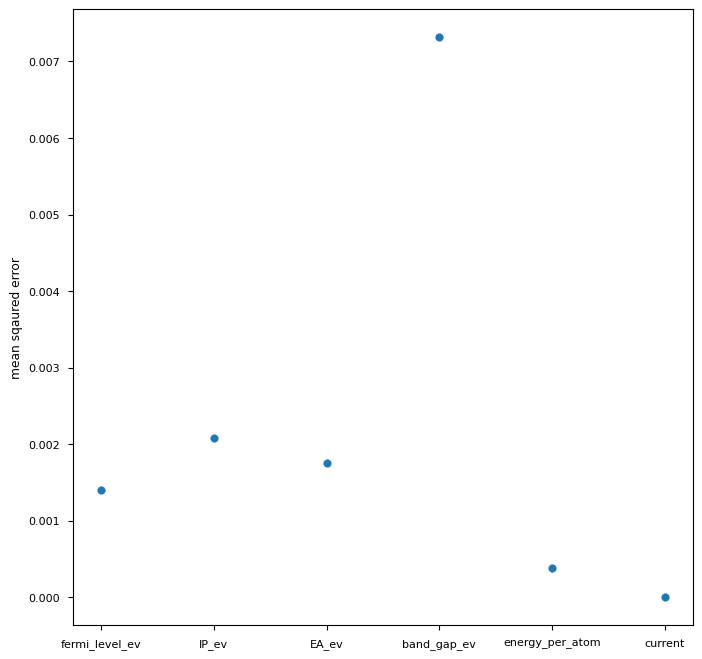

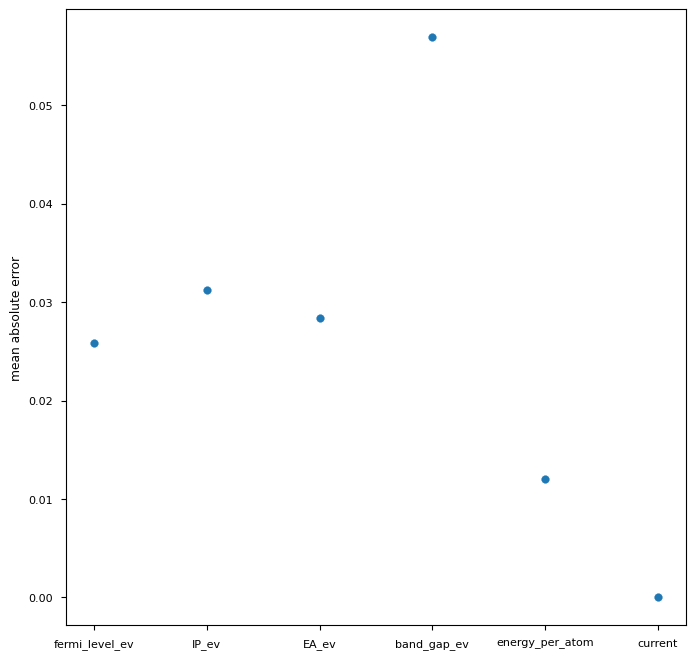

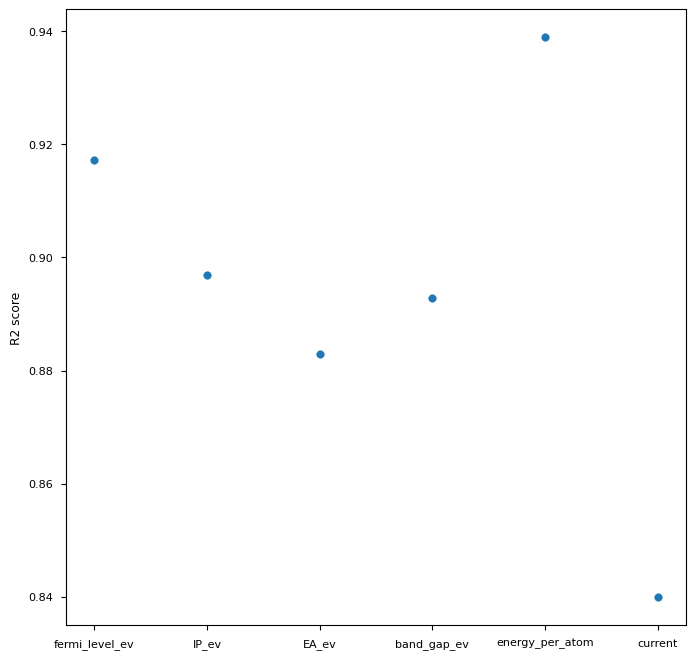

In [15]:
plt.figure(figsize=(8, 8))
plt.scatter(target_list, scores_array[:, 0])
plt.ylabel("mean sqaured error")
plt.figure(figsize=(8, 8))
plt.scatter(target_list, scores_array[:, 1])
plt.ylabel("mean absolute error")
plt.figure(figsize=(8, 8))
plt.scatter(target_list, scores_array[:, 2])
plt.ylabel("R2 score")

<Figure size 800x800 with 0 Axes>

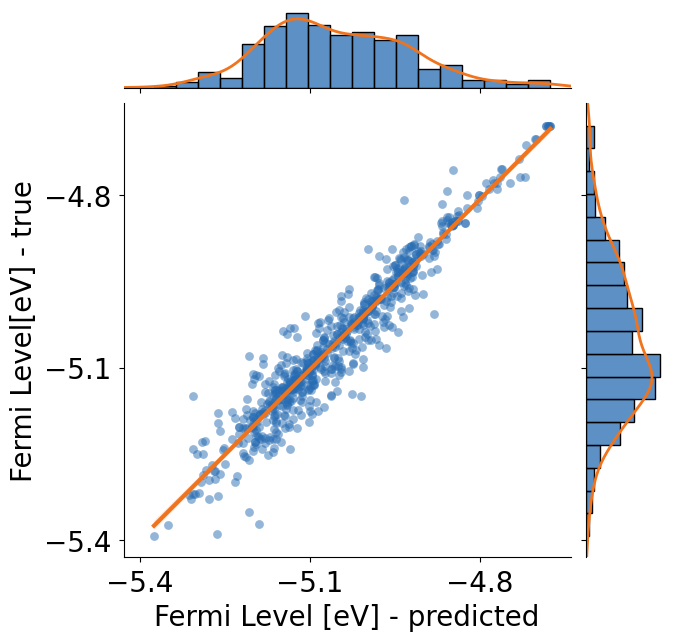

<Figure size 800x800 with 0 Axes>

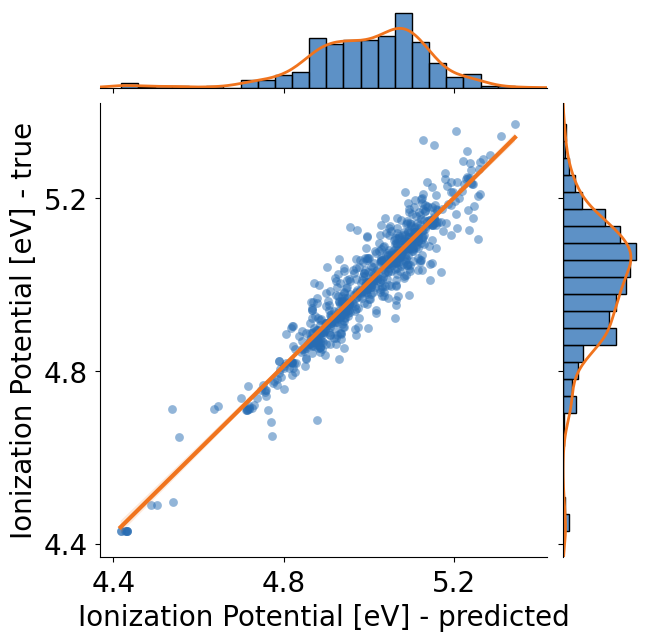

<Figure size 800x800 with 0 Axes>

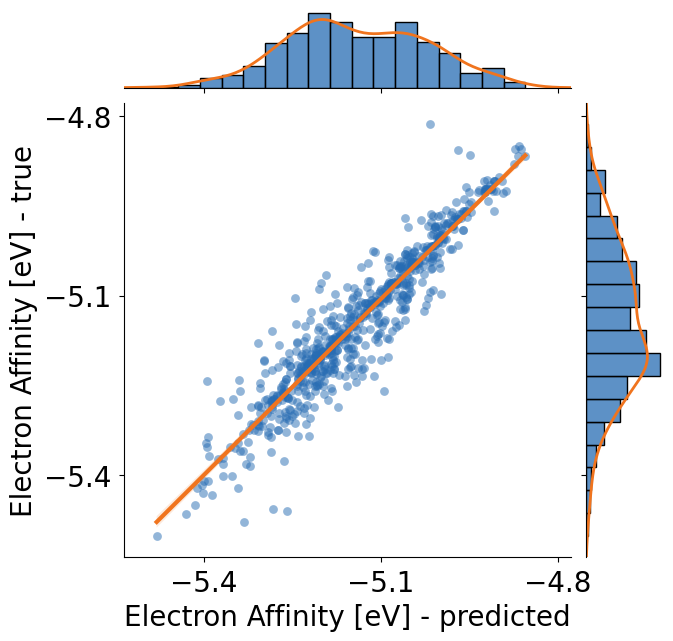

<Figure size 800x800 with 0 Axes>

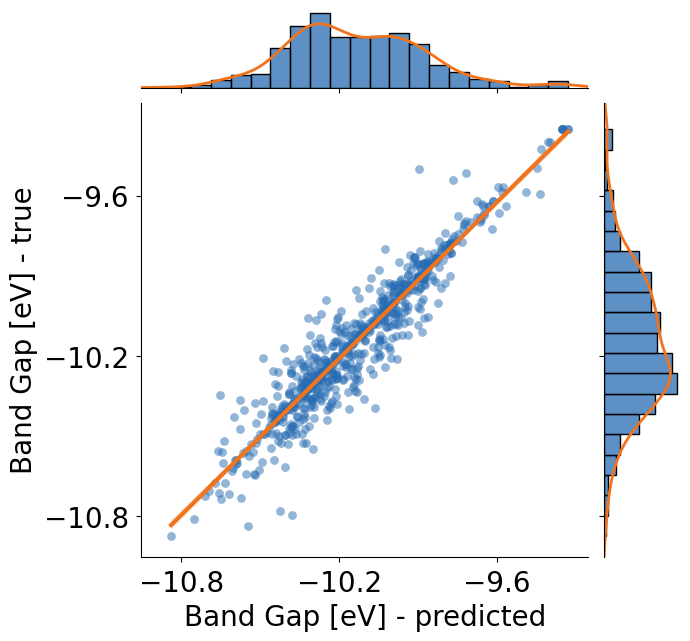

<Figure size 800x800 with 0 Axes>

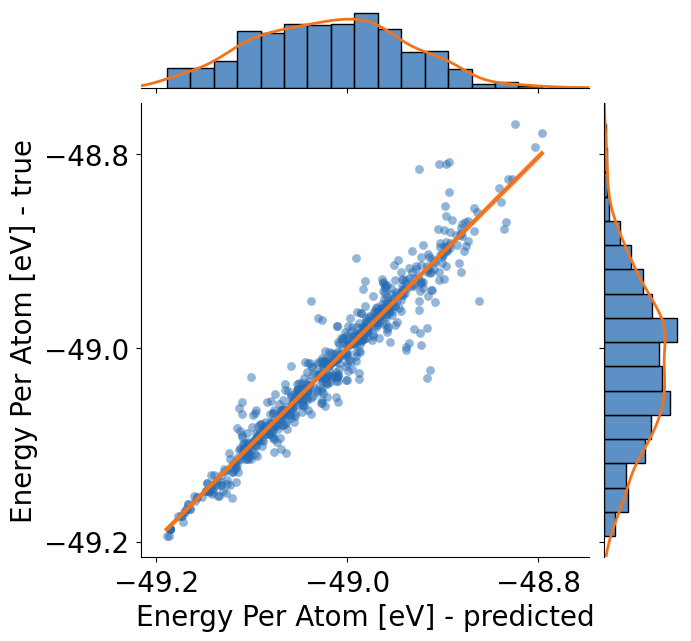

<Figure size 800x800 with 0 Axes>

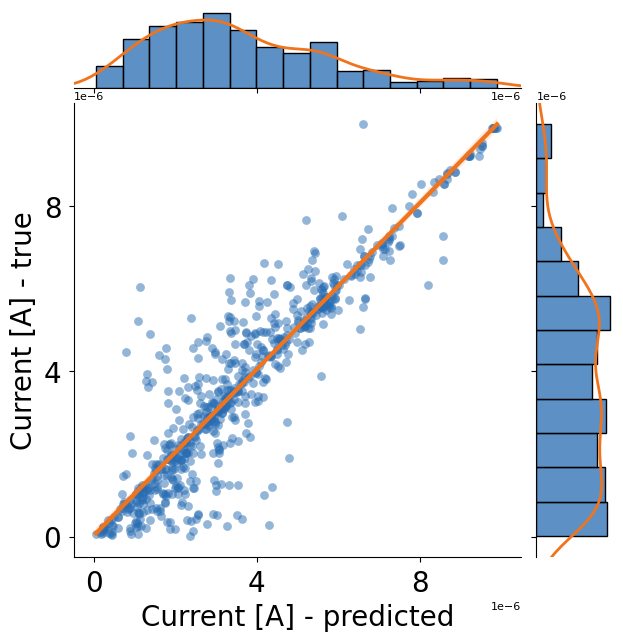

In [17]:
# colors =["#ED4638","#0A2C52"]
# colors = ["#CE4F38", "#1D5CAF"]
colors = ["#F0741E", "#276CB3"]
target_labels = {
    "fermi_level_ev": ("Fermi Level [eV] - predicted", "Fermi Level[eV] - true"),
    "EA_ev": ("Electron Affinity [eV] - predicted", "Electron Affinity [eV] - true"),
    "IP_ev": (
        "Ionization Potential [eV] - predicted",
        "Ionization Potential [eV] - true",
    ),
    "band_gap_ev": ("Band Gap [eV] - predicted", "Band Gap [eV] - true"),
    "energy_per_atom": (
        "Energy Per Atom [eV] - predicted",
        "Energy Per Atom [eV] - true",
    ),
    "current": (
        "Current [A] - predicted",
        "Current [A] - true",
    ),
}
for target in target_list:
    df = pd.read_csv(pred_path.joinpath(f"{target}_predictions.csv"), header=0)

    MAX = np.max(
        [df[f"{target}_predicted"].to_numpy(), df[f"{target}_real"].to_numpy()]
    )
    MIN = np.min(
        [df[f"{target}_predicted"].to_numpy(), df[f"{target}_real"].to_numpy()]
    )

    offset = 0.05 * np.abs(MAX - MIN)
    bound = [MIN - offset, MAX + offset]

    fig = plt.figure(figsize=(8, 8))

    g = sns.JointGrid()
    x, y = df[f"{target}_predicted"], df[f"{target}_real"]
    sns.regplot(
        x=f"{target}_predicted",
        y=f"{target}_real",
        data=df,
        ax=g.ax_joint,
        scatter_kws={"s": 40, "alpha": 0.5, "color": colors[1]},
        line_kws={"linewidth": 3, "alpha": 1, "color": colors[0]},
    )
    sns.histplot(
        x=x,
        fill=True,
        linewidth=1,
        kde=False,
        ax=g.ax_marg_x,
        stat="density",
        color=colors[1],
    )
    sns.kdeplot(x=x, linewidth=2, ax=g.ax_marg_x, color=colors[0])
    sns.histplot(
        y=y,
        fill=True,
        linewidth=1,
        kde=False,
        ax=g.ax_marg_y,
        stat="density",
        color=colors[1],
    )
    sns.kdeplot(y=y, linewidth=2, ax=g.ax_marg_y, color=colors[0])
    # g.ax_joint.set_xticks(ticks)
    # g.ax_joint.set_yticks(ticks)
    g.ax_joint.set_xlim(bound)
    g.ax_joint.set_ylim(bound)
    g.ax_joint.tick_params(axis="both", which="major", labelsize=20)
    g.ax_joint.xaxis.set_major_locator(MaxNLocator(nbins=3))  # Auto tick locator
    g.ax_joint.yaxis.set_major_locator(MaxNLocator(nbins=3))  #
    g.set_axis_labels(
        target_labels[f"{target}"][0], target_labels[f"{target}"][1], fontsize=20
    )

    plt.savefig(plot_path.joinpath(f"{target}_fit.png"), dpi=300, bbox_inches="tight")

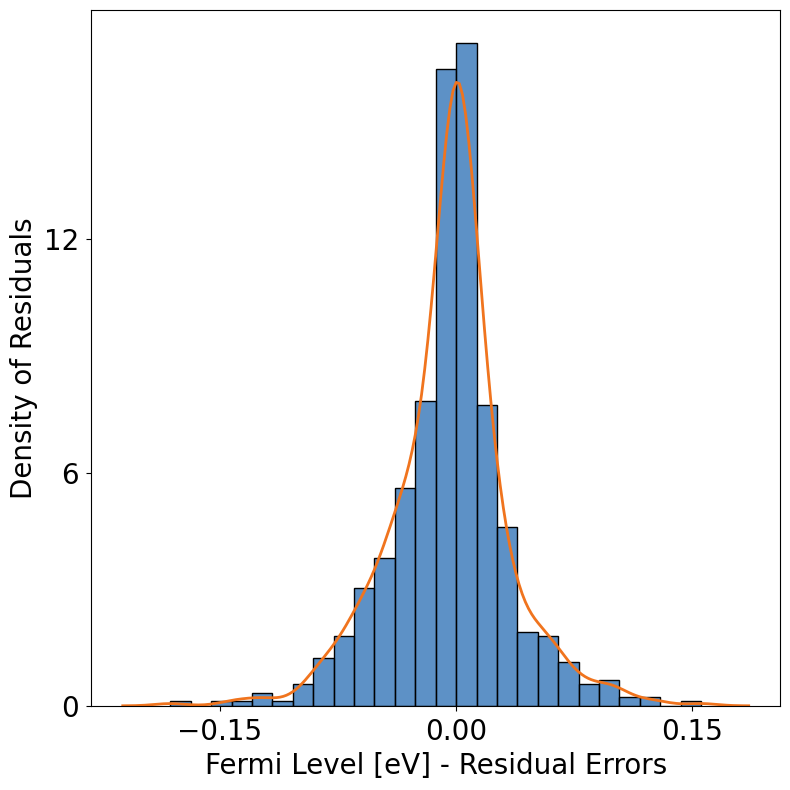

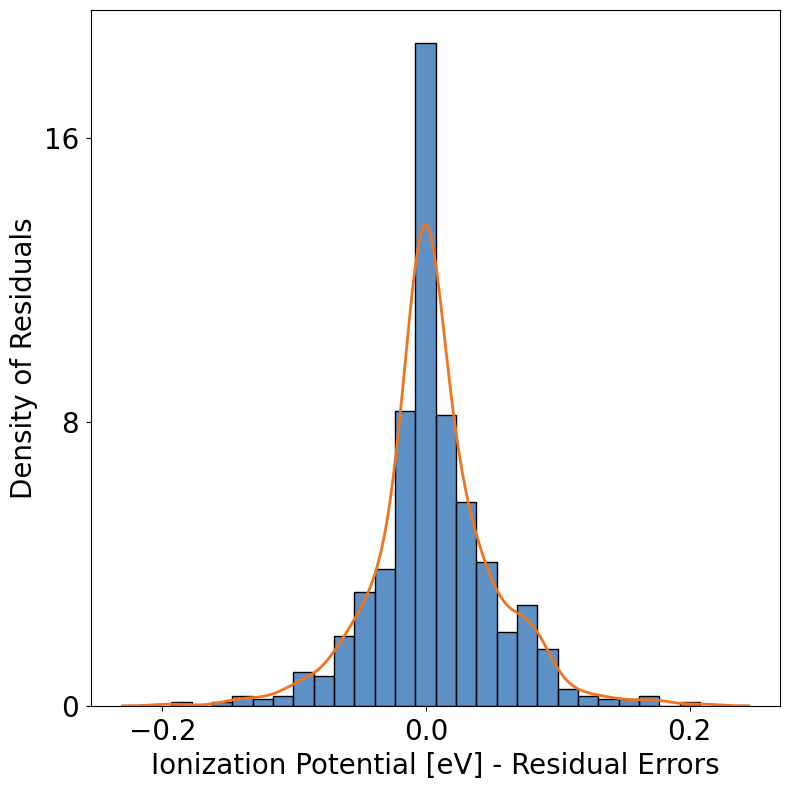

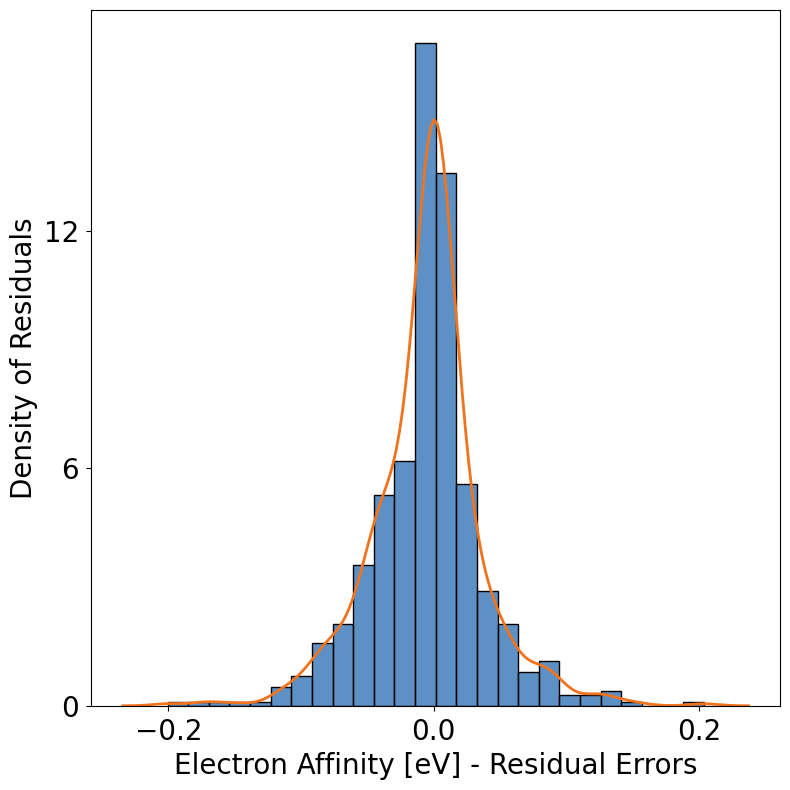

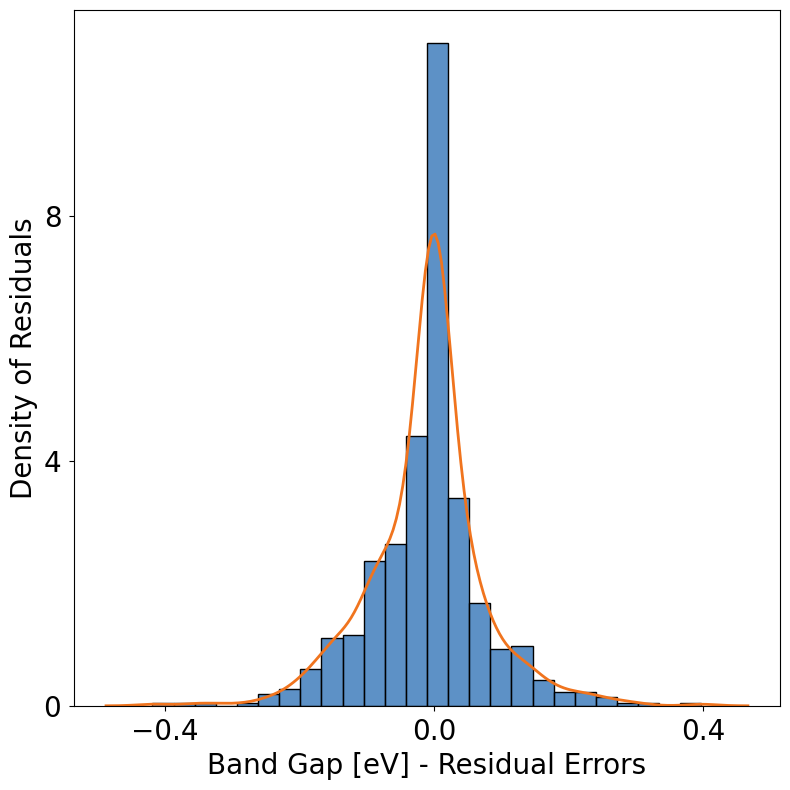

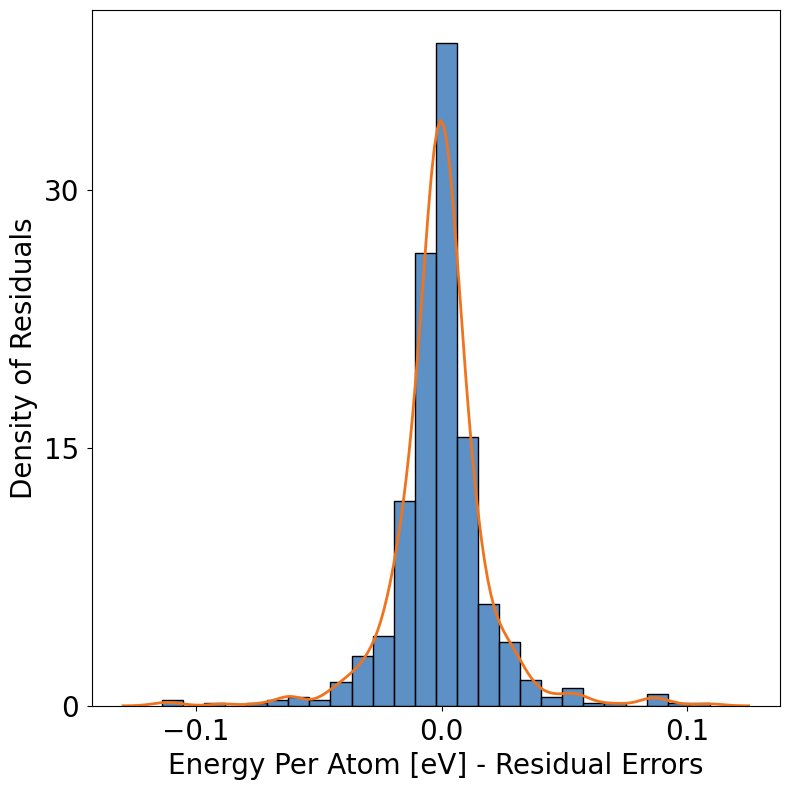

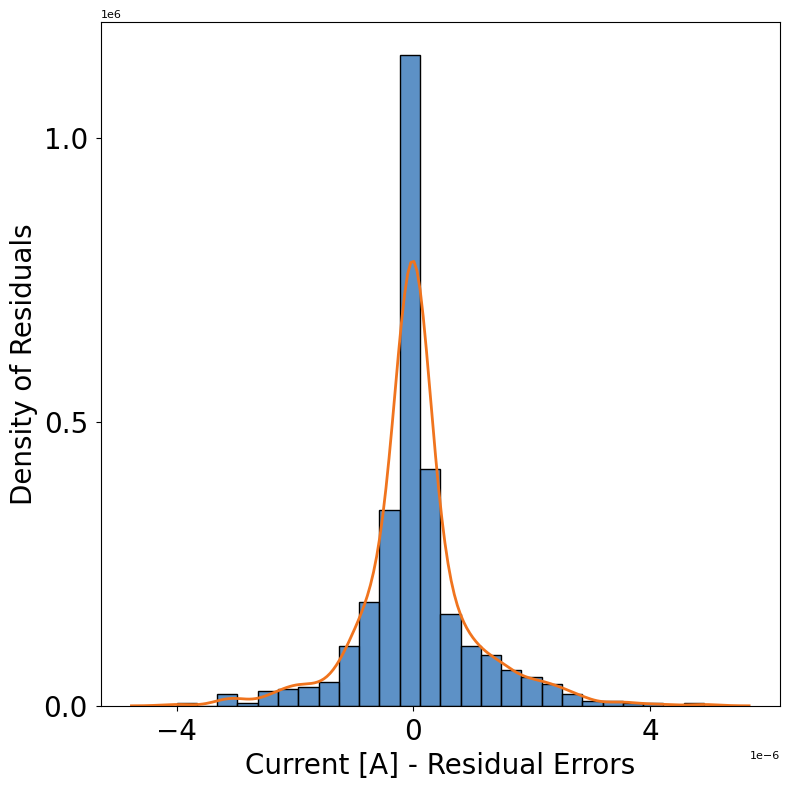

In [21]:
target_labels = {
    "fermi_level_ev": ("Fermi Level [eV] - Residual Errors", "Density of Residuals"),
    "EA_ev": ("Electron Affinity [eV] - Residual Errors", "Density of Residuals"),
    "IP_ev": (
        "Ionization Potential [eV] - Residual Errors",
        "Density of Residuals",
    ),
    "band_gap_ev": ("Band Gap [eV] - Residual Errors", "Density of Residuals"),
    "energy_per_atom": (
        "Energy Per Atom [eV] - Residual Errors",
        "Density of Residuals",
    ),
    "current": (
        "Current [A] - Residual Errors",
        "Density of Residuals",
    ),
}
for target in target_list:
    fig = plt.figure(figsize=(8, 8))
    df = pd.read_csv(pred_path.joinpath(f"{target}_predictions.csv"), header=0)
    ax = fig.add_subplot(1, 1, 1)  # Aggiungi subplot

    sns.histplot(
        x=df[f"{target}_residual"],
        fill=True,
        linewidth=1,
        kde=False,
        stat="density",
        color=colors[1],
        ax=ax,
        bins=int(np.sqrt(len(df[f"{target}_residual"]))),
    )

    sns.kdeplot(x=df[f"{target}_residual"], linewidth=2, color=colors[0], ax=ax)

    ax.xaxis.set_major_locator(
        MaxNLocator(nbins=3)
    )  # Imposta massimo 3 ticks sull'asse x
    ax.yaxis.set_major_locator(
        MaxNLocator(nbins=3)
    )  # Imposta massimo 3 ticks sull'asse y
    ax.set_xlabel(target_labels[target][0], fontsize=20)
    ax.set_ylabel(target_labels[target][1], fontsize=20)
    plt.tick_params(axis="both", which="major", labelsize=20)
    plt.tight_layout()
    plt.savefig(
        plot_path.joinpath(f"{target}_residual.png"), dpi=300, bbox_inches="tight"
    )

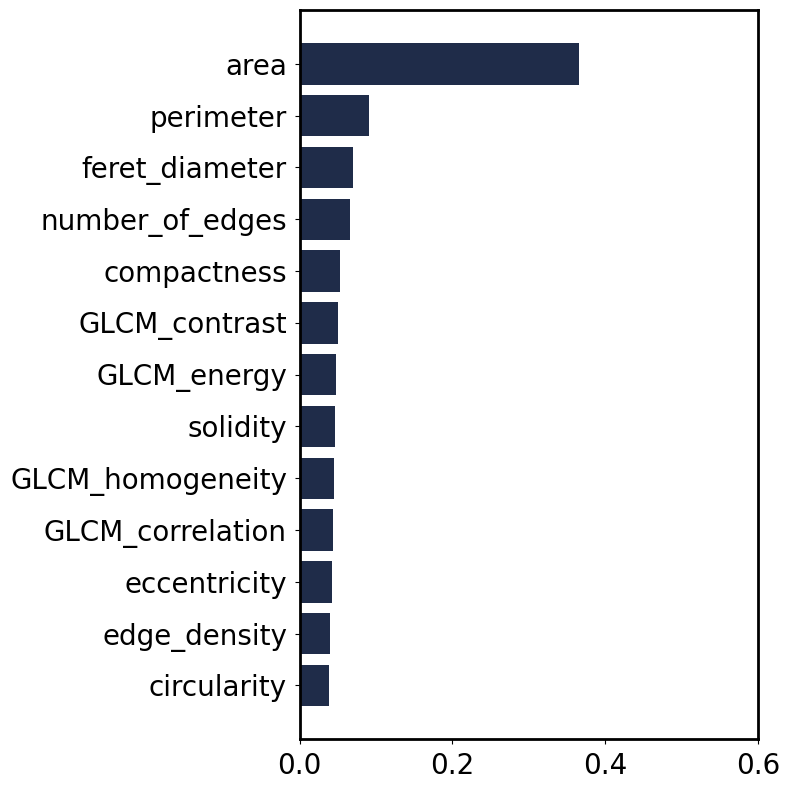

In [22]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
plt.barh(
    pos,
    feature_importance[sorted_idx],
    align="center",
    color=[31 / 255, 44 / 255, 73 / 255],
)
plt.yticks(pos, np.array(features_list)[sorted_idx], fontsize=20)
plt.xticks([0, 0.2, 0.4, 0.6], fontsize=20)
result = permutation_importance(
    model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
# plt.subplot(1, 2, 2)
# plt.boxplot(
#     result.importances[sorted_idx].T,
#     vert=False,
#     labels=np.array(features_list)[sorted_idx],
# )
# plt.title("Permutation Importance (test set)")

for spine in plt.gca().spines.values():
    spine.set_linewidth(2)
fig.tight_layout()
plt.savefig(plot_path.joinpath("features_imp.png"))
plt.show()